In [185]:
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm
import xgboost as xgb
from ipynb.fs.defs.yasa_model import calc_features
import joblib

plt.style.use('dark_background')
pd.options.display.precision = 10

In [ ]:
joblib_file = 'model_try.pkl'
jl_model = joblib.load(joblib_file)
features_names = pd.read_csv('features.csv').columns.tolist()

In [2]:
####################
# MAIN PARAMETERS
####################

# Bandpass filter
freq_broad = (0.1, 500)
# FFT & bandpower parameters
sr = 1000
bands = [
    (0.1, 4, 'delta'), (4, 8, 'theta'),
    (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
    (30, 75, 'gamma'), (75, 300, 'fast')
]

In [157]:
def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
    return np.array(epochs)

def get_one_y_bi(subj):
    x_right = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', 'SEEG RAH1-REF')
    feat_right = calc_features(x_right)
    y_right = jl_model.predict(feat_right[features_names[1:]])

    x_left = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', 'SEEG LAH1-REF')
    feat_left = calc_features(x_left)
    y_left = jl_model.predict(feat_left[features_names[1:]])
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

def get_y_bi_prob(subj):
    x_right = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', 'SEEG RAH1-REF')
    feat_right = calc_features(x_right)
    y_right_prob = jl_model.predict_proba(feat_right[features_names[1:]]).T
    y_right = [1 if p > 0.85 else 0 for p in y_right_prob[1]]

    x_left = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', 'SEEG LAH1-REF')
    feat_left = calc_features(x_left)
    y_left_prob = jl_model.predict_proba(feat_left[features_names[1:]]).T
    y_left = [1 if p > 0.85 else 0 for p in y_left_prob[1]]
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

In [ ]:
y_406_bi = get_one_y_bi('406')
y_402_bi = get_one_y_bi('402')

In [ ]:
y_406_bi_prob = get_y_bi_prob('406')
y_402_bi_prob = get_y_bi_prob('402')

In [138]:
# jl_model.feature_importances_

In [142]:
len(np.where(y_402_bi==1)[0])

2631

In [166]:
y_402_bi

array([1., 0., 0., ..., 0., 0., 0.])

In [168]:
len(np.where(np.array(y_402_bi_prob)==True))

1

In [167]:
np.array(y_402_bi_prob)

array([1, 0, 0, ..., 0, 0, 0])

In [140]:
# plt.rcParams["figure.figsize"] = (15,7)
# lightgbm.plot_importance(jl_model)

In [ ]:
# i_pred = np.where(y==1)[0]
# for i in i_pred[:10]:
#     plt.figure()
#     pred_view = np.concatenate(x[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(1000, 1250), x[i], c='red')

In [184]:
# x = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'SEEG RAH1-REF')
# feat = calc_features(x)
# y = jl_model.predict(feat[features_names[1:]])
#
# x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'EOG EOG2-REF')
# feat_eye = calc_features(x_eye)

# TODO: why its not the same length?
X_train, X_test, y_train, y_test = train_test_split(feat_eye, y_402_bi[:len(feat_eye)], stratify=y_402_bi[:len(feat_eye)], random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[20:38:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
x = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf', 'SEEG RAH1-REF')
feat = calc_features(x)
y = jl_model.predict(feat[features_names[1:]])

x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf', 'EOG EOG2-REF')
feat_eye = calc_features(x_eye)



In [187]:
# EOG2 model #

X_train, X_test, y_train, y_test = train_test_split(feat_eye, y, stratify=y, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[20:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[17:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


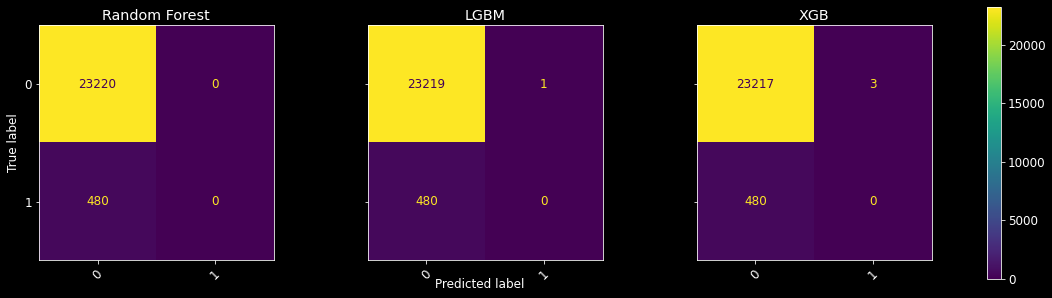

In [48]:
# PZ model #
x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'EEG PZ-REF')
feat_eye = calc_features(x_eye)


X_train, X_test, y_train, y_test = train_test_split(feat_eye, y, stratify=y, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[17:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


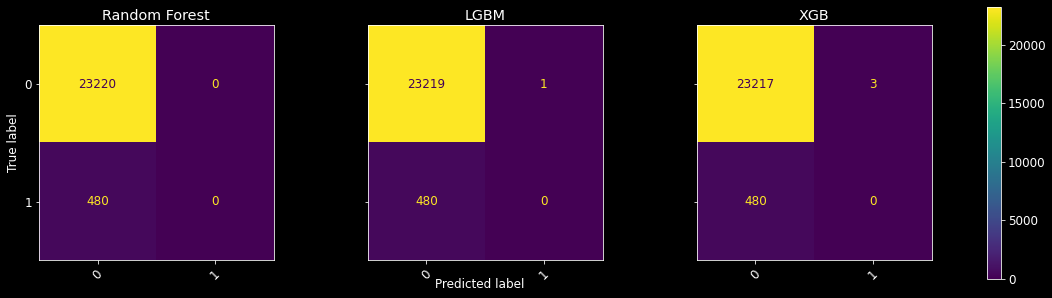

In [49]:
# C4 model #
x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'EEG C4-REF')
feat_eye = calc_features(x_eye)


X_train, X_test, y_train, y_test = train_test_split(feat_eye, y, stratify=y, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[17:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


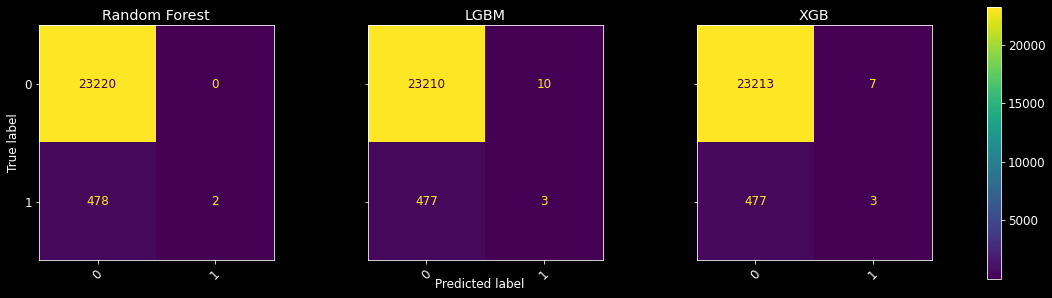

In [50]:
# EOG1 model #
x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'EOG EOG1-REF')
feat_eye = calc_features(x_eye)


X_train, X_test, y_train, y_test = train_test_split(feat_eye, y, stratify=y, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [51]:
x_left = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'SEEG LAH1-REF')
feat_left = calc_features(x_left)
y_left = jl_model.predict(feat_left[features_names[1:]])
y_all = y + y_left
y_all[y_all == 2] = 1

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


array([0., 0., 0., ..., 0., 0., 0.])

In [53]:
y_all[y_all == 2] = 1

array([], dtype=float64)

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[18:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


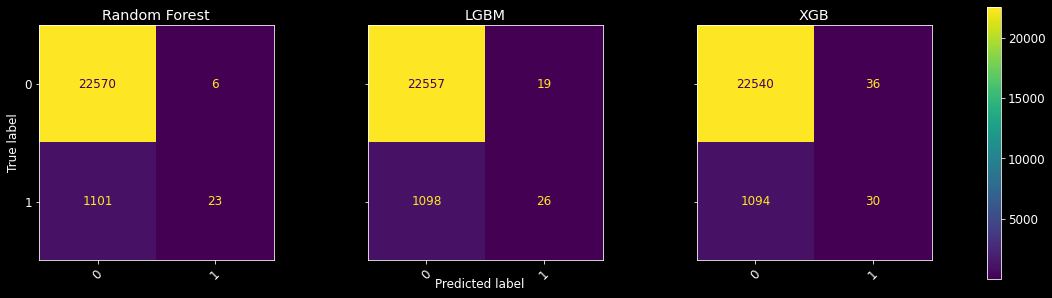

In [54]:
x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'EOG EOG2-REF')
feat_eye = calc_features(x_eye)


X_train, X_test, y_train, y_test = train_test_split(feat_eye, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# subject 402
x_402 = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf', 'SEEG RAH1-REF')
feat_402 = calc_features(x_402)
y_402 = jl_model.predict(feat_402[features_names[1:]])

x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf', 'EOG EOG2-REF')
feat_eye = calc_features(x_eye)


X_train, X_test, y_train, y_test = train_test_split(feat_eye, y_402, stratify=y_402, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [90]:
# union channels and subjects
def run_all():
    x_all = np.empty((0, 250))
    y_all = np.empty(0)
    feat_all = pd.DataFrame()
    features = pd.DataFrame()
    y_subj = None
    # create y array
    for subj in ['402', '406']:
        for channel in ['RAH1', 'LAH1']:
            x_curr = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', f'SEEG {channel}-REF')
            feat_curr = calc_features(x_curr)
            y_curr = jl_model.predict(feat_curr[features_names[1:]])
            if y_subj is None:
                y_subj = np.zeros(len(y_curr))
            y_subj = y_subj + y_curr
            y_subj[y_subj == 2] = 1
        y_all = np.concatenate((y_all, y_subj))
        y_subj = None

    # create features for 2 eyes
    for subj in ['402', '406']:
        for channel in ['EOG1', 'EOG2']:
            x_curr = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', f'EOG {channel}-REF')
            x_all = np.concatenate((x_all, x_curr))
            feat_curr = calc_features(x_curr).add_prefix(f'{channel}_')
            features = pd.concat([features, feat_curr], axis=1)

        feat_all = pd.concat([feat_all, features], axis=0)
        features = pd.DataFrame()

    return x_all, feat_all, y_all

In [ ]:
x_all, feat_all, y_all = run_all()

[20:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


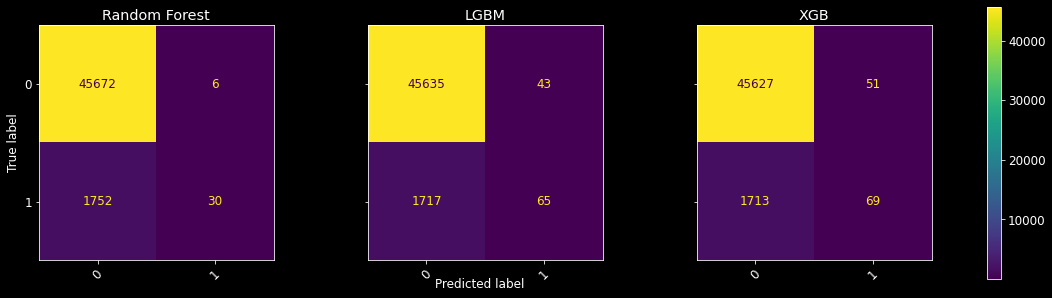

In [88]:
# subject 402 + 406
X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
x_all, feat_all, y_all = run_all()
all_col = feat_all.columns
selector = VarianceThreshold(.1)
selector.fit_transform(feat_all)
feat_all = feat_all[feat_all.columns[selector.get_support(indices=True)]]

# subject 402 + 406

X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[20:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


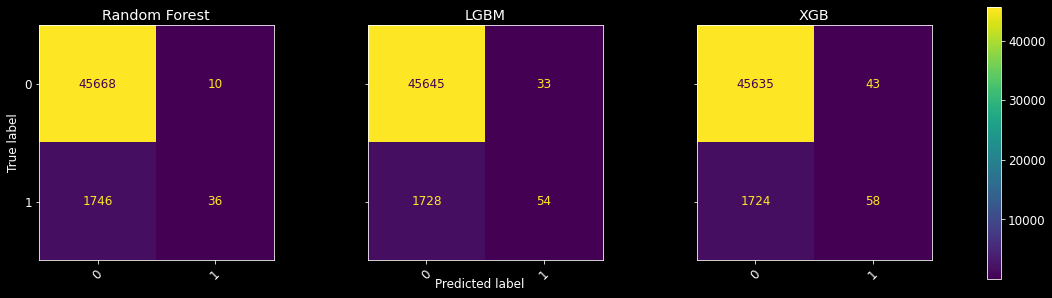

In [89]:
# subject 402 + 406 only EOG2
eog2_feat = feat_all.loc[:, feat_all.columns.str.startswith("EOG2")]
X_train, X_test, y_train, y_test = train_test_split(eog2_feat, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [82]:
feat_all

,EOG1_std,EOG1_iqr,EOG1_skew,EOG1_kurt,EOG1_nzc,EOG1_hmob,EOG1_hcomp,EOG1_theta,EOG1_alpha,EOG1_sigma,...,EOG2_fast_pmin_norm,EOG2_at_pmin_norm,EOG2_gt_pmin_norm,EOG2_ft_pmin_norm,EOG2_ag_pmin_norm,EOG2_af_pmin_norm,EOG2_abspow_pmin_norm,EOG2_perm_pmin_norm,EOG2_higuchi_pmin_norm,EOG2_petrosian_pmin_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.0000128736,0.0000199467,-0.2716413384,-0.8807789265,3,0.0630019858,4.5110506362,0.2342585611,0.4279188775,0.2414375632,...,-0.0760830552,1.1578466389,-0.0005830484,-0.0223213391,-0.0625303611,-0.0602732161,0.3468134929,-0.2209976879,-0.1608104351,-0.1741569402
1,0.0000122359,0.0000219577,0.1450511571,-1.2575262875,0,0.0492130731,7.4116568925,0.7237201294,0.1822614034,0.0371030225,...,-0.0485896456,0.1107950387,-0.0102578563,-0.0254313307,-0.0300772413,-0.0407080216,0.0273810158,0.0594729675,0.2247874082,0.0434336884
2,0.0000119657,0.0000225876,0.2904861759,-1.4171907517,7,0.0480207904,7.6041407767,0.9679301265,0.1450480708,0.0103626072,...,-0.0337197634,-0.0791136303,-0.0276589966,-0.0266955805,-0.0199391664,-0.0206119871,0.1412543506,0.1782733192,0.0933859142,0.1734832294
3,0.0000070682,0.0000072906,-1.2255720182,1.9402324485,1,0.0905666041,3.7239648860,0.3310281463,0.2453027344,0.2974598818,...,0.5670906198,-0.0207718004,0.6465550916,0.4651039197,0.8427614851,0.6049581807,-0.1736375180,-0.0716689719,0.2479171892,-0.0869938079
4,0.0000084265,0.0000133481,0.6120629490,-0.7709775451,2,0.0753829843,4.5754722242,0.6161535059,0.2809774013,0.0492355469,...,-0.0883999008,-0.0029054637,-0.0490986318,-0.0517969637,-0.0602527546,-0.0627408110,0.4719487224,-0.1588007538,-0.1005837424,-0.2178022858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94795,0.0000193124,0.0000341511,0.5361069658,-1.0751869971,0,0.0304171580,6.4971701731,0.9162409079,0.1829809175,0.0080083314,...,-0.0681520558,-0.1621958451,-0.0474233968,-0.0389760804,-0.0391391438,-0.0386078977,0.5182669647,-0.4286309924,-0.3623258772,-0.4760216385
94796,0.0000095531,0.0000176220,-0.1635944978,-1.4574385357,0,0.0459084536,4.9966345079,0.5786727257,0.2948279822,0.0631411341,...,-0.0645357267,0.7868904436,-0.0233294382,-0.0265373921,-0.0541397203,-0.0435596937,0.0824952463,-0.2622788949,-0.3235501210,-0.3168734940
94797,0.0000227052,0.0000481315,-0.0436118204,-1.4405838024,0,0.0321652868,4.6618472815,0.7393090507,0.2400462396,0.0154893447,...,-0.0483775448,-0.0359911096,-0.0433258766,-0.0277354896,-0.0459615931,-0.0290532566,0.1224518863,-0.0494903963,-0.2516170308,-0.1054150487


In [85]:
feat_all.columns.tolist()

['EOG1_std',
 'EOG1_iqr',
 'EOG1_skew',
 'EOG1_kurt',
 'EOG1_nzc',
 'EOG1_hmob',
 'EOG1_hcomp',
 'EOG1_theta',
 'EOG1_alpha',
 'EOG1_sigma',
 'EOG1_beta',
 'EOG1_gamma',
 'EOG1_fast',
 'EOG1_at',
 'EOG1_gt',
 'EOG1_ft',
 'EOG1_ag',
 'EOG1_af',
 'EOG1_abspow',
 'EOG1_perm',
 'EOG1_higuchi',
 'EOG1_petrosian',
 'EOG1_std_cmin_norm',
 'EOG1_iqr_cmin_norm',
 'EOG1_skew_cmin_norm',
 'EOG1_kurt_cmin_norm',
 'EOG1_nzc_cmin_norm',
 'EOG1_hmob_cmin_norm',
 'EOG1_hcomp_cmin_norm',
 'EOG1_theta_cmin_norm',
 'EOG1_alpha_cmin_norm',
 'EOG1_sigma_cmin_norm',
 'EOG1_beta_cmin_norm',
 'EOG1_gamma_cmin_norm',
 'EOG1_fast_cmin_norm',
 'EOG1_at_cmin_norm',
 'EOG1_gt_cmin_norm',
 'EOG1_ft_cmin_norm',
 'EOG1_ag_cmin_norm',
 'EOG1_af_cmin_norm',
 'EOG1_abspow_cmin_norm',
 'EOG1_perm_cmin_norm',
 'EOG1_higuchi_cmin_norm',
 'EOG1_petrosian_cmin_norm',
 'EOG1_std_pmin_norm',
 'EOG1_iqr_pmin_norm',
 'EOG1_skew_pmin_norm',
 'EOG1_kurt_pmin_norm',
 'EOG1_nzc_pmin_norm',
 'EOG1_hmob_pmin_norm',
 'EOG1_hcomp_pmin_n

<AxesSubplot:>

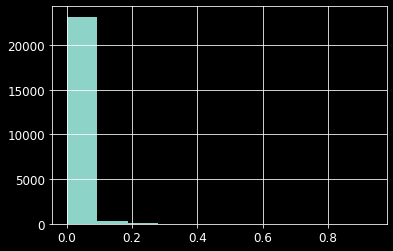

In [105]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob[prob[0] < 0.99].sort_values(by=prob.columns[1])[1].hist()


<AxesSubplot:>

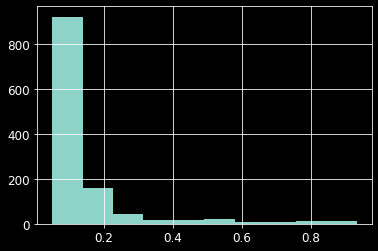

In [110]:
prob[prob[0] < 0.95].sort_values(by=prob.columns[1])[1].hist()

<AxesSubplot:>

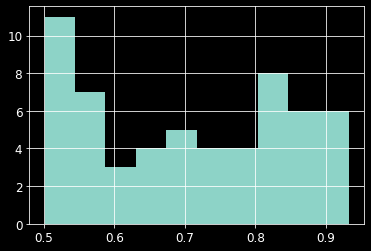

In [111]:
prob[prob[0] < 0.5].sort_values(by=prob.columns[1])[1].hist()


In [120]:
prob[prob[1] > 0.8]

,0,1
1653,0.1950729533,0.8049270467
4802,0.0670808524,0.9329191476
5823,0.0859042207,0.9140957793
6788,0.1551129379,0.8448870621
7550,0.1904161691,0.8095838309
9034,0.0887498460,0.9112501540
9401,0.1882604851,0.8117395149
9648,0.1769513408,0.8230486592
9986,0.1265502009,0.8734497991
10115,0.1470840943,0.8529159057


In [119]:
prob.T

,0,1,2,3,4,5,6,7,8,9,...,23690,23691,23692,23693,23694,23695,23696,23697,23698,23699
0,0.9792334993,0.9899814096,0.9936363417,0.9986918195,0.9736285091,0.9809770185,0.9960767873,0.9949168869,0.9984067273,0.9906943782,...,0.9841846373,0.9838004667,0.9920176636,0.9975607981,0.9964100873,0.9931237007,0.9890348297,0.9919490099,0.9973101149,0.991546077
1,0.0207665007,0.0100185904,0.0063636583,0.0013081805,0.0263714909,0.0190229815,0.0039232127,0.0050831131,0.0015932727,0.0093056218,...,0.0158153627,0.0161995333,0.0079823364,0.0024392019,0.0035899127,0.0068762993,0.0109651703,0.0080509901,0.0026898851,0.008453923


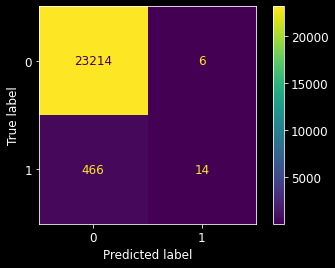

In [131]:
cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in prob[1]])
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()

In [146]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob

,0,1
0,0.9792334993,0.0207665007
1,0.9899814096,0.0100185904
2,0.9936363417,0.0063636583
3,0.9986918195,0.0013081805
4,0.9736285091,0.0263714909
...,...,...
23695,0.9931237007,0.0068762993
23696,0.9890348297,0.0109651703
23697,0.9919490099,0.0080509901
23698,0.9973101149,0.0026898851


In [155]:
subj = '402'
x_right = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', 'SEEG RAH1-REF')
feat_right = calc_features(x_right)
y_right_prob = jl_model.predict_proba(feat_right[features_names[1:]]).T
y_right = [p > 0.85 for p in y_right_prob[1]]
y_right_prob
# x_left = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', 'SEEG LAH1-REF')
# feat_left = calc_features(x_left)
# y_left_prob = jl_model.predict_proba(feat_left[features_names[1:]])
# y_left = [p > 0.85 for p in y_left_prob[1]]
# y_all = y_right + y_left
# y_all[y_all == 2] = 1

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


array([[2.18813728e-01, 9.99933836e-01, 9.99989763e-01, ...,
        9.99991090e-01, 9.99994772e-01, 9.99989886e-01],
       [7.81186272e-01, 6.61644644e-05, 1.02367510e-05, ...,
        8.90995923e-06, 5.22826589e-06, 1.01144647e-05]])

In [160]:
pd.DataFrame(y_right_prob)

,0,1,2,3,4,5,6,7,8,9,...,95029,95030,95031,95032,95033,95034,95035,95036,95037,95038
0,0.2188137285,0.9999338355,0.9999897632,0.9999849408,0.9999404316,0.0214208952,0.9984924322,0.999990501,0.9999800273,0.9999361217,...,0.9999963685,0.9999946405,0.9999959739,0.999979633,0.9994005297,0.999982399,0.9999612036,0.99999109,0.9999947717,0.9999898855
1,0.7811862715,0.0000661645,0.0000102368,0.0000150592,0.0000595684,0.9785791048,0.0015075678,0.000009499,0.0000199727,0.0000638783,...,0.0000036315,0.0000053595,0.0000040261,0.000020367,0.0005994703,0.000017601,0.0000387964,0.00000891,0.0000052283,0.0000101145


In [161]:
y_right = [p > 0.85 for p in y_right_prob[1]]

In [162]:
y_right

[False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa

In [154]:
y_right_prob[]

array([0.21881373, 0.78118627])

In [170]:
health_raw = mne.io.read_raw_egi('/Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff')


Reading EGI MFF Header from /Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...


<ipython-input-170-32665a3a045f>:1: RuntimeWarning: Did not find any event code with more than one event.
  health_raw = mne.io.read_raw_egi('/Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff')


AttributeError: 'RawMff' object has no attribute 'chan'

In [174]:
health_raw.info['ch_names']

['E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E15',
 'E16',
 'E17',
 'E18',
 'E19',
 'E20',
 'E21',
 'E22',
 'E23',
 'E24',
 'E25',
 'E26',
 'E27',
 'E28',
 'E29',
 'E30',
 'E31',
 'E32',
 'E33',
 'E34',
 'E35',
 'E36',
 'E37',
 'E38',
 'E39',
 'E40',
 'E41',
 'E42',
 'E43',
 'E44',
 'E45',
 'E46',
 'E47',
 'E48',
 'E49',
 'E50',
 'E51',
 'E52',
 'E53',
 'E54',
 'E55',
 'E56',
 'E57',
 'E58',
 'E59',
 'E60',
 'E61',
 'E62',
 'E63',
 'E64',
 'E65',
 'E66',
 'E67',
 'E68',
 'E69',
 'E70',
 'E71',
 'E72',
 'E73',
 'E74',
 'E75',
 'E76',
 'E77',
 'E78',
 'E79',
 'E80',
 'E81',
 'E82',
 'E83',
 'E84',
 'E85',
 'E86',
 'E87',
 'E88',
 'E89',
 'E90',
 'E91',
 'E92',
 'E93',
 'E94',
 'E95',
 'E96',
 'E97',
 'E98',
 'E99',
 'E100',
 'E101',
 'E102',
 'E103',
 'E104',
 'E105',
 'E106',
 'E107',
 'E108',
 'E109',
 'E110',
 'E111',
 'E112',
 'E113',
 'E114',
 'E115',
 'E116',
 'E117',
 'E118',
 'E119',
 'E120',
 'E121',
 'E122',
 'E123',
 

In [176]:
# this is the  left set referenced to RM, while EOG referenced to LM
selected_set = [['E226', 'E46', 'E104', 'E35', 'E59', 'E116', 'E201'],
                ['EOG E1-LM', 'EOG E2-LM', 'LM', 'EEG F3-RM', 'EEG C3-RM', 'EEG O1-RM', 'RM']]
health_raw.pick_channels(selected_set[0]).resample(sr)
# order channels according to selected set, MNE default is alphabetical
health_raw.reorder_channels(selected_set[0])

# rename channels
health_raw.rename_channels({id: name for (id, name) in zip(selected_set[0], selected_set[1])})
# set EOG channels as MNE type "ecog" for re-refrencing
health_raw.set_channel_types({selected_set[1][i]: 'ecog' for i in range(2)})
# re-reference channels
health_raw.set_eeg_reference(ref_channels=[selected_set[1][2]], ch_type='ecog')
health_raw.set_channel_types({selected_set[1][i]: 'eog' for i in range(2)})
health_raw.drop_channels([selected_set[1][2], selected_set[1][6]])

Applying a custom ECoG reference.


TypeError: copy() got an unexpected keyword argument 'tmax'

In [178]:
health_raw

In [194]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[20:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [195]:
epochs = []
health_data = health_raw.pick_channels(['EOG E2-LM']).get_data()[0]
window_size = 250
for i in range(0, len(health_data), window_size):
    curr_block = health_data[i: i  + window_size]
    if i + window_size < len(health_data):
        epochs.append(curr_block)
epochs = np.array(epochs)

feat_healthy_eye = calc_features(epochs)
y_healthy_pred = classifiers['LGBM'].predict(feat_healthy_eye)

/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


In [205]:
len(y_healthy_pred[y_healthy_pred == 1])

162

In [203]:
pd.DataFrame(feat_healthy_eye)

,std,iqr,skew,kurt,nzc,hmob,hcomp,theta,alpha,sigma,...,fast_pmin_norm,at_pmin_norm,gt_pmin_norm,ft_pmin_norm,ag_pmin_norm,af_pmin_norm,abspow_pmin_norm,perm_pmin_norm,higuchi_pmin_norm,petrosian_pmin_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.0000075539,0.0000096504,-0.2421958300,-0.1117589311,0,0.4543540034,2.9807514207,0.2355668088,0.0553939852,0.0203593506,...,0.1469202340,-0.2761984977,-0.0203212345,-0.0113626131,0.1045128792,0.1430332347,-0.1167928092,0.0034714785,0.0057355029,-0.0588675248
1,0.0000066761,0.0000095492,-0.1243751518,-0.0846559161,0,0.4829503716,2.6677794357,0.2652677703,0.1489585522,0.0599768599,...,-0.1005633687,-0.1474279271,-0.0199569092,-0.0481084253,0.0036721440,-0.0248118669,-0.0945571471,-0.5419984627,0.0075643338,-0.5334272146
2,0.0000073864,0.0000100149,0.2813221255,-0.4094662977,0,0.4023953290,3.4013268859,0.0363706737,0.1685263188,0.2688655155,...,-0.2068621133,1.4591195304,0.0291793089,0.0706165228,-0.0524487609,-0.0434083215,-0.0621957478,-0.2035306908,-0.2631214259,-0.2360686024
3,0.0000109666,0.0000128826,-0.4713583613,0.2083148368,0,0.3181732938,4.3221294127,0.2761152260,0.2019474120,0.0193963952,...,0.0154360533,-0.0804175729,-0.0509186928,-0.0363974570,-0.0473974164,-0.0232214527,-0.1123583314,-0.0320008000,-0.1730004318,-0.0588675248
4,0.0000073230,0.0000097720,0.2211239749,0.0469000940,0,0.4308363626,3.0224434735,0.0738137541,0.0489147753,0.0748998690,...,-0.0539316472,-0.1075257842,0.1426283929,0.0577199520,0.1894382921,0.0812328833,-0.1123159489,-0.1113413636,-0.2121641461,-0.1769013567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10428,0.0000000045,0.0000000089,0.0000000108,-2.0000000000,0,1.9999838711,1.0000161290,0.0182608773,0.0071800362,0.0156090153,...,0.8736959636,-0.2138465610,0.6767327352,2.0548565503,1.4578271337,3.7576345677,-0.1774720469,-3.7037720662,7.3982904893,3.6063772921
10429,0.0000000045,0.0000000089,0.0000000191,-2.0000000000,0,1.9999838711,1.0000161290,0.0834725850,0.0088203978,0.0176793494,...,0.7412203185,-0.3272839227,0.0932030729,0.3367914231,1.1808126139,2.7188816089,-0.1774720469,-3.3884366852,7.4150637738,3.6063772921
10430,0.0000000045,0.0000000089,0.0000000187,-2.0000000000,0,1.9999838712,1.0000161290,0.2499411339,0.0110090386,0.0158032237,...,0.6777300221,-0.3515956250,-0.0051941354,0.0504167728,1.1368866453,2.0393585636,-0.1774720469,-3.4034610060,7.4207471228,3.6063772921


In [204]:
x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf', 'EOG EOG1-REF')
feat_eye1 = calc_features(x_eye)
y_healthy_pred = classifiers['LGBM'].predict(feat_eye1)

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P402_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
